In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')
from utils import *
import pickle
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
candidates_mapping = {
    0 : "Arthaud",
    1 : "Asselineau",
    2 : "Cheminade",
    3 : "Dupont-Aignan",
    4 : "Fillon",
    5 : "Hamon",
    6 : "Lassalle",
    7 : "Le Pen",
    8 : "Macron",
    9 : "Mélenchon",
    10 : "Poutou"
}

In [4]:
f = open("../communities/v1/partition", "rb")
partition = pickle.load(f)
f.close()

In [5]:
f = open("../communities/v1/nb_tweets_per_user", "rb")
nb_tweets_per_user = pickle.load(f)
f.close()
f = open("../communities/v1/graph", "rb")
G = pickle.load(f)
f.close()

In [8]:
values = list(partition.values())
# for each community, count number of users belonging to it
c = Counter(values)
# sort communities in descending order with respect to their number of users
communities_id_sorted = sorted(np.unique(values), key=c.get, reverse=True)

In [9]:
# create array where first column = community, second column = size of community
communities_counts = [(community_id, c[community_id]) for community_id in communities_id_sorted]
communities_counts = np.array(communities_counts)

In [45]:
communities_filtered = communities_counts[np.where(communities_counts[:,1] >= 100)][:,0]

In [48]:
# remove parts of the graph that are unrelated to the k biggest communities
partition_filtered, G_filtered, nb_tweets_per_user_filtered = filter_graph_community(partition, G, \
                                                                         nb_tweets_per_user,\
                                                                         communities_filtered)

In [21]:
# compute new graph layout
pos = community_layout(G_filtered, partition_filtered)

../src/community_graph.py:42: RuntimeWarning: divide by zero encountered in log
  _node_size = np.log(np.array([dict_node_size.get(node) for node in G.nodes()]))


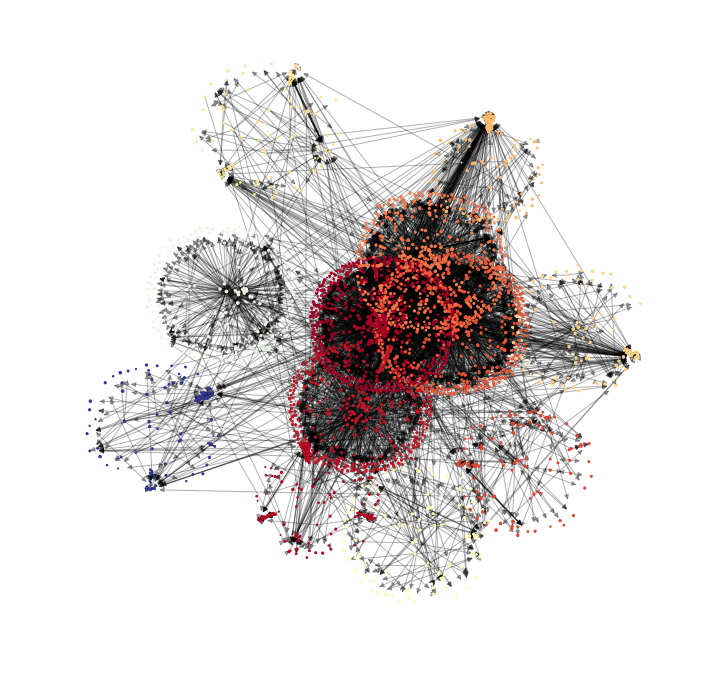

In [22]:
plot_community_graph(G_filtered, pos, partition_filtered, nb_tweets_per_user_filtered)

In [49]:
# create array out of partition_filtered
partition_filtered_array = np.array([(user_id, community) for (user_id, community) in partition_filtered.items()])

In [50]:
# create array out of nb_tweets_per_user
nb_tweets_filtered_array = np.array([(user_id, nb) for (user_id, nb) in nb_tweets_per_user_filtered.items()])

In [51]:
k = len(communities_filtered)

In [53]:
# element i of communities is the subarray of partition_filtered_array corresponding to the ith biggest community
communities = []
for i in range(k):
    com = partition_filtered_array[np.where(partition_filtered_array[:,1] == communities_filtered[i])]
    communities.append(com)

In [57]:
candidates_to_community = dict()
mapped = np.zeros(11)

In [58]:
for i in range(k):
    # get users from ith biggest community
    users = communities[i][:,0]
    # compute average number of tweets among this community
    avg = np.mean(nb_tweets_filtered_array[np.where(np.in1d(nb_tweets_filtered_array[:,0], users))][:,1])
    candidates = mentioned_candidates_from_mult_users(tuple(users),10000)
    cand = np.argmax(np.sum(candidates, axis=0))
    
    if mapped[cand] == 0:
        candidates_to_community[cand] = communities[i]
        mapped[cand] = 1
        
    print("Community {} - average number of tweets per user : {} - most mentioned candidate : {}"\
          .format(communities_filtered[i], avg, candidates_mapping[cand]))

Community 0 - average number of tweets per user : 301.51662049861494 - most mentioned candidate : Mélenchon
Community 6 - average number of tweets per user : 238.42930153321976 - most mentioned candidate : Macron
Community 8 - average number of tweets per user : 156.32562277580072 - most mentioned candidate : Le Pen
Community 2 - average number of tweets per user : 181.62020202020202 - most mentioned candidate : Fillon
Community 1 - average number of tweets per user : 39.78512396694215 - most mentioned candidate : Fillon
Community 21 - average number of tweets per user : 205.5 - most mentioned candidate : Hamon
Community 12 - average number of tweets per user : 102.75449101796407 - most mentioned candidate : Mélenchon
Community 5 - average number of tweets per user : 170.17094017094018 - most mentioned candidate : Macron
Community 18 - average number of tweets per user : 149.75675675675674 - most mentioned candidate : Fillon
Community 14 - average number of tweets per user : 154.962962

In [60]:
for k,v in candidates_to_community.items():
    print("{} -> community {}".format(candidates_mapping[k], v[0][1]))

Macron -> community 6
Mélenchon -> community 0
Fillon -> community 2
Hamon -> community 21
Le Pen -> community 8


## Analysis of community 0 (Mélenchon)

In [17]:
partition_0, G_0, nb_tweets_0 = filter_graph_community(partition, G, nb_tweets_per_user, [top_communities[0]])

In [18]:
pos_0 = community_layout(G_0, partition_0)

In [19]:
users_0 = communities[0][:,0]

In [21]:
cand_colors = get_nodes_color(users_0)

100 nodes color computed
200 nodes color computed
300 nodes color computed
400 nodes color computed
500 nodes color computed
600 nodes color computed
700 nodes color computed


/Users/lauranguyen/Documents/UPMC/M1/S2/PLDAC/PLDAC_TWITTER/community_graph.py:29: RuntimeWarning: divide by zero encountered in log
  _node_size = np.log(np.array([dict_node_size.get(node) for node in G.nodes()]))


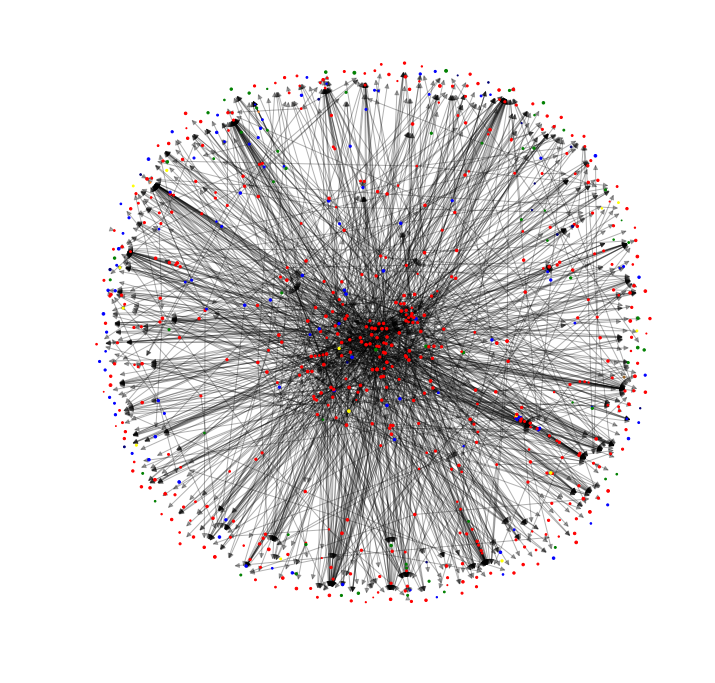

In [33]:
plot_community_graph(G_0, pos_0, partition_0, nb_tweets_0, dict_node_color=cand_colors)

In [31]:
count_colors = Counter(list(cand_colors.values()))
count_colors

Counter({'#000075': 15,
         '#9A6324': 1,
         '#f58231': 3,
         'blue': 115,
         'green': 70,
         'red': 502,
         'yellow': 16})

In [101]:
dict_centrality = nx.degree_centrality(G_0)
nodes_centrality_sorted = sorted(dict_centrality.items(), key=lambda kv: kv[1], reverse=True)

# central nodes and their degree centrality
for i in range(10):
    print(nodes_centrality_sorted[i])

(145058470, 0.07489597780859918)
(834855615340150787, 0.07212205270457697)
(818847510546546690, 0.0638002773925104)
(264404407, 0.0638002773925104)
(3023497329, 0.06102635228848821)
(808398248696287232, 0.06102635228848821)
(329686497, 0.059639389736477116)
(717406522930806784, 0.059639389736477116)
(2437430341, 0.05825242718446602)
(805349615222620160, 0.054091539528432736)


In [103]:
nodes_centrality_sorted = np.array(nodes_centrality_sorted)
# set threshold to eliminate users that do not sufficiently belong to the community
nodes_centrality_filtered = nodes_centrality_sorted[nodes_centrality_sorted[:,1] > 0.004]

In [104]:
partition_0_f = dict()
G_0_f = G_0.copy()
nb_tweets_0_f = dict()
for user_id, comm_id in partition_0.items():
    if user_id in nodes_centrality_filtered[:,0]:
        partition_0_f [user_id] = comm_id
        nb_tweets_0_f[user_id] = nb_tweets_0[user_id]
    else:
        G_0_f.remove_node(user_id)

In [98]:
pos_0_f = community_layout(G_0_f, partition_0_f)

/Users/lauranguyen/Documents/UPMC/M1/S2/PLDAC/PLDAC_TWITTER/community_graph.py:42: RuntimeWarning: divide by zero encountered in log
  _node_size = np.log(np.array([dict_node_size.get(node) for node in G.nodes()]))


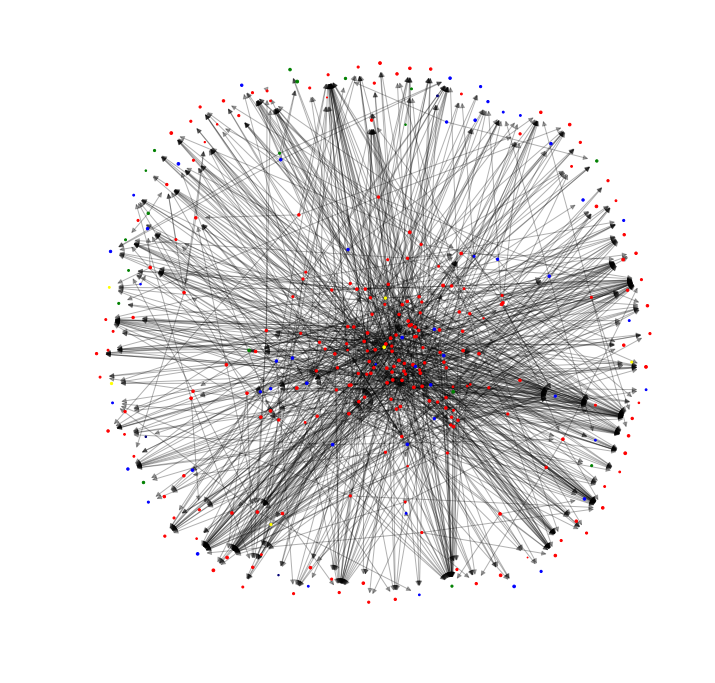

In [99]:
plot_community_graph(G_0_f, pos_0_f, partition_0_f, nb_tweets_0_f, dict_node_color=cand_colors)